In [38]:
%%bash
exit 0


# you can use environment.yml file to set up the environment
mamba env create -f environment.yml
mamba activate cg-idps



In [39]:
import pandas as pd

# Load the data from the pickle file
M1 = pd.read_pickle('ICL2.pkl')

# Assuming the DataFrame M1 has the experimental PRE data
# where column 1 is x (residue numbers) and column 2 is y (PRE values)
# Extract x and y
x = M1.iloc[:, 0]  # First column as x-axis
y = M1.iloc[:, 1]  # Second column as y-axis

# Combine into a new DataFrame
df = pd.DataFrame({'resid': x, 'exp_PRE': y})

# Display the processed DataFrame
print(df)

         resid   exp_PRE
0   415.453039  0.497942
1   416.513812  0.339506
2   419.607735  0.413580
3   420.933702  0.376543
4   422.348066  0.251029
..         ...       ...
58  506.856354  0.362140
59  510.215470  0.253086
60  511.099448  0.660494
61  511.895028  0.633745
62  513.044199  0.831276

[63 rows x 2 columns]


In [41]:
import glob
import os
from DEERPREdict.PRE import PREpredict
import MDAnalysis

# Define function to evaluate PRE
def evaluatePRE(pdb_path, dcd_path, label):
    rep=pdb_path.split("/")[-3]
    ff=pdb_path.split("/")[-2]
    
    os.makedirs(os.path.join("calcPREs", rep, ff), exist_ok=True)
    
    u = MDAnalysis.Universe(pdb_path, dcd_path)
    PRE = PREpredict(u, label, log_file='file.log', temperature=283, atom_selection='N', sigma_scaling=1.0)  # Cbeta=True
    PRE.run(output_prefix='calcPREs/' + rep + "/" + ff + "/" + "res", load_file=False, tau_t=1e-10, tau_c=1.0*1e-09, r_2=10, wh=700)

# Loop over directories containing the simulation files
for dir_path in glob.glob("shortened_trajs/*/*/"):
    gro_files = glob.glob(os.path.join(dir_path, "temp_md_2000ns.gro"))
    xtc_files = glob.glob(os.path.join(dir_path, "shortened.xtc"))

    # Ensure we have exactly one gro and one xtc file in each directory
    if len(gro_files) != 1 or len(xtc_files) != 1:
        print(f"Skipping directory {dir_path}: unexpected number of gro or xtc files.")
        continue

    gro_file = gro_files[0]
    xtc_file = xtc_files[0]

    print(f"Processing {gro_file} and {xtc_file}...")

    # Specify residues for which PRE should be calculated
    residues = [24]  # Replace with your list of residues

    for residue in residues:
        evaluatePRE(gro_file, xtc_file, residue)




Processing shortened_trajs/replica_05/AMBER99SBWS/temp_md_2000ns.gro and shortened_trajs/replica_05/AMBER99SBWS/shortened.xtc...
Processing shortened_trajs/replica_05/AMBER03WS/temp_md_2000ns.gro and shortened_trajs/replica_05/AMBER03WS/shortened.xtc...
Processing shortened_trajs/replica_05/CHARMM36M/temp_md_2000ns.gro and shortened_trajs/replica_05/CHARMM36M/shortened.xtc...
Processing shortened_trajs/replica_05/DESAMBER/temp_md_2000ns.gro and shortened_trajs/replica_05/DESAMBER/shortened.xtc...
Processing shortened_trajs/replica_05/AMBER99SB-DISP/temp_md_2000ns.gro and shortened_trajs/replica_05/AMBER99SB-DISP/shortened.xtc...
Processing shortened_trajs/replica_03/AMBER99SBWS/temp_md_2000ns.gro and shortened_trajs/replica_03/AMBER99SBWS/shortened.xtc...
Processing shortened_trajs/replica_03/AMBER03WS/temp_md_2000ns.gro and shortened_trajs/replica_03/AMBER03WS/shortened.xtc...
Processing shortened_trajs/replica_03/CHARMM36M/temp_md_2000ns.gro and shortened_trajs/replica_03/CHARMM36M/s

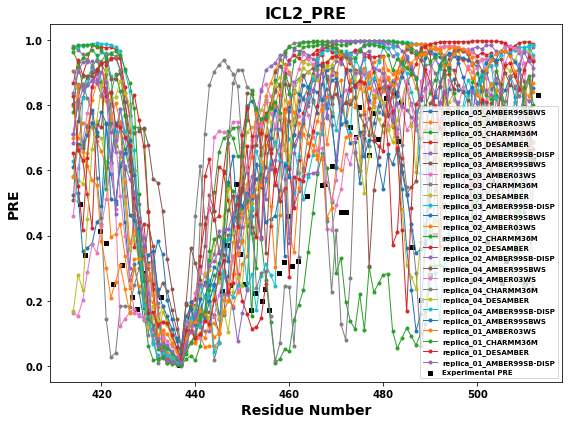

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 6))

res_data_fold = glob.glob("calcPREs" + "/*/*")

for i in res_data_fold:
    # Load PRE from simulations into a DataFrame
    name=i.split("/")[-2] + "_" + i.split("/")[-1]
    filename = i + '/res-24.dat'
    df_sim = pd.read_csv(
        filename,
        delim_whitespace=True,
        skiprows=1,
        names=['residue', 'i_ratio', 'gamma_2']
    )


    df_sim['residue'] = df_sim['residue'].astype(int)
    df_sim['residue'] += 412
    df_sim = df_sim.rename(columns={'residue': 'resid'})
    df_sim['i_ratio'] = df_sim['i_ratio'].interpolate(method='linear')

    ax.plot(
        df_sim['resid'], 
        df_sim['i_ratio'],  
        linewidth=1, 
        marker='o', 
        markersize=3, 
        label=name
    )

    plt.rcParams.update({'font.size': 10, 'font.weight': 'bold'})

    title = 'ICL2_PRE'



    df['exp_PRE'] = df['exp_PRE'].interpolate(method='linear')
    df_sim['i_ratio'] = df_sim['i_ratio'].interpolate(method='linear')
    # Scatter plot for experimental PRE data
    ax.scatter(
        df['resid'], 
        df[f'exp_PRE'], 
        marker='s', 
        s=10, 
        color='black', 
        label='Experimental PRE'
    )


    ax.set_xlabel('Residue Number', fontsize=14, fontweight='bold')
    ax.set_ylabel('PRE', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig('ICL2_all.pdf')
plt.show()


